In [ ]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv       dataframe_flow_variable_60min.csv
dataframe_dma_flow_60min.csv    DMA_225.csv
dataframe_flow_1D.csv           DMA_468.csv
dataframe_flow_variable_1D.csv  persistence_results.pkl


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')

In [ ]:
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )

In [ ]:
data_DMA225 = data[['Date_time','DMA_225']]

In [ ]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')

In [ ]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()
data_hourly = hourly_data.values

#Scaling the data 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_hourly)
scaled_hourlydata = pd.DataFrame(scaled_data)

# Restructuring the data
def reshaped_hourlydata(data,step_input,step_output):
  final_data =  np.array([data[i:i + (step_input+step_output)].copy() for i in range(len(data) - (step_input+step_output))])
  return final_data

final_hourlydata = reshaped_hourlydata(scaled_hourlydata,12,24)
#final_hourlydata = reshaped_hourlydata(data_hourly,12,24)
final_hourlydata.shape

(8724, 36, 1)

In [ ]:
train_size = int(len(final_hourlydata)*0.6)
remaining_data = len(final_hourlydata) - train_size
# With the remaining data 70% is considered for validation set and 30% for test set.
validation_data = int((remaining_data)*0.7)
testing_data = remaining_data-validation_data
valid_size = (train_size)+(validation_data)
#valid_size = int(len(final_hourlydata)*0.9)
#train_size = 5234
# valid_size = 7415
# Restructing the dataset:
step_input = 12
step_output = 24

train_X = final_hourlydata[:train_size, :step_input]
valid_X = final_hourlydata[train_size:valid_size, :step_input]
test_X = final_hourlydata[valid_size:, :step_input]
y = np.empty((len(final_hourlydata), step_input, step_output))
for future_value in range(1, step_output + 1):
    y[..., future_value - 1] = final_hourlydata[..., future_value:future_value + step_input, 0]
train_y = y[:train_size]
valid_y = y[train_size:valid_size]
test_y = y[valid_size:]

print("The shape of train_X is:",train_X.shape)
print("The shape of valid_X is:",valid_X.shape)
print("The shape of test_X is:",test_X.shape)

print("The shape of train_y is:",train_y.shape)
print("The shape of valid_y is:",valid_y.shape)
print("The shape of test_y is:",test_y.shape)

The shape of train_X is: (5234, 12, 1)
The shape of valid_X is: (2443, 12, 1)
The shape of test_X is: (1047, 12, 1)
The shape of train_y is: (5234, 12, 24)
The shape of valid_y is: (2443, 12, 24)
The shape of test_y is: (1047, 12, 24)


In [ ]:
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64,return_sequences= True, input_shape=(12,1)),
    tf.keras.layers.Dropout(0.16),
    tf.keras.layers.LSTM(32,return_sequences= True),
    tf.keras.layers.Dropout(0.38),
    tf.keras.layers.LSTM(16,return_sequences= True),
    tf.keras.layers.Dropout(0.47),
    tf.keras.layers.TimeDistributed(keras.layers.Dense(24))
])

LSTM_model.compile(loss="mse", optimizer='adam')
history = LSTM_model.fit(train_X,train_y, epochs=150,validation_data=(valid_X, valid_y), callbacks=[EarlyStopping(monitor='val_loss',patience=4)] )

Epoch 1/150
164/164 [==============================] - 9s 28ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 2/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/150
164/164 [==============================] - 4s 22ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/150
164/164 [==============================] - 4s 22ms/step - loss: 0.001

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

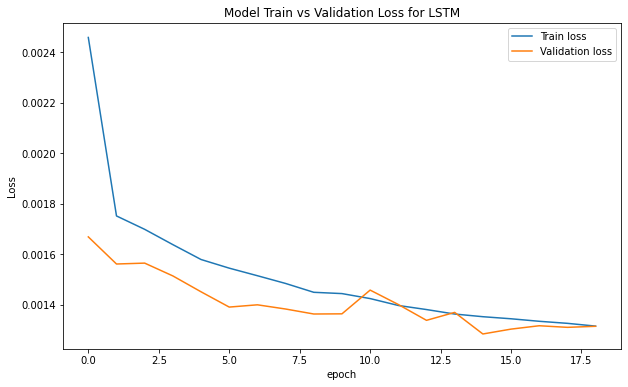

In [ ]:
plot_loss(history,'LSTM')

In [ ]:
#Generate predictions
train_pred = LSTM_model.predict(train_X)
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = LSTM_model.predict(test_X)
predictions = test_pred

In [ ]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(predictions)):
  lstm_df.append((predictions[i][0][step_output-1]))
final_df = pd.DataFrame((test_y[:,0]))
final_df.rename(columns = {0:'original_value'}, inplace = True)
final_df['predicted_value'] = lstm_df

In [ ]:
# To calculate the percentage difference between actual and predicted value:
final_df['total_difference'] = (final_df['predicted_value'] - final_df['original_value']).abs()
final_df['percentage_difference'] = ((final_df['total_difference'])/(final_df['original_value']))*100

In [ ]:
import math
from sklearn.metrics import mean_squared_error
testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.010909165782887004


In [ ]:
# To make complete df:
y = [y[0] for y in test_y]
df_r = hourly_data.reset_index()
days = df_r['Date_time'].values[-len(y):]
df = pd.DataFrame(days,columns = ['Date_time'])
result = pd.concat([df, final_df], axis=1, join='inner')
result.shape

(1047, 28)

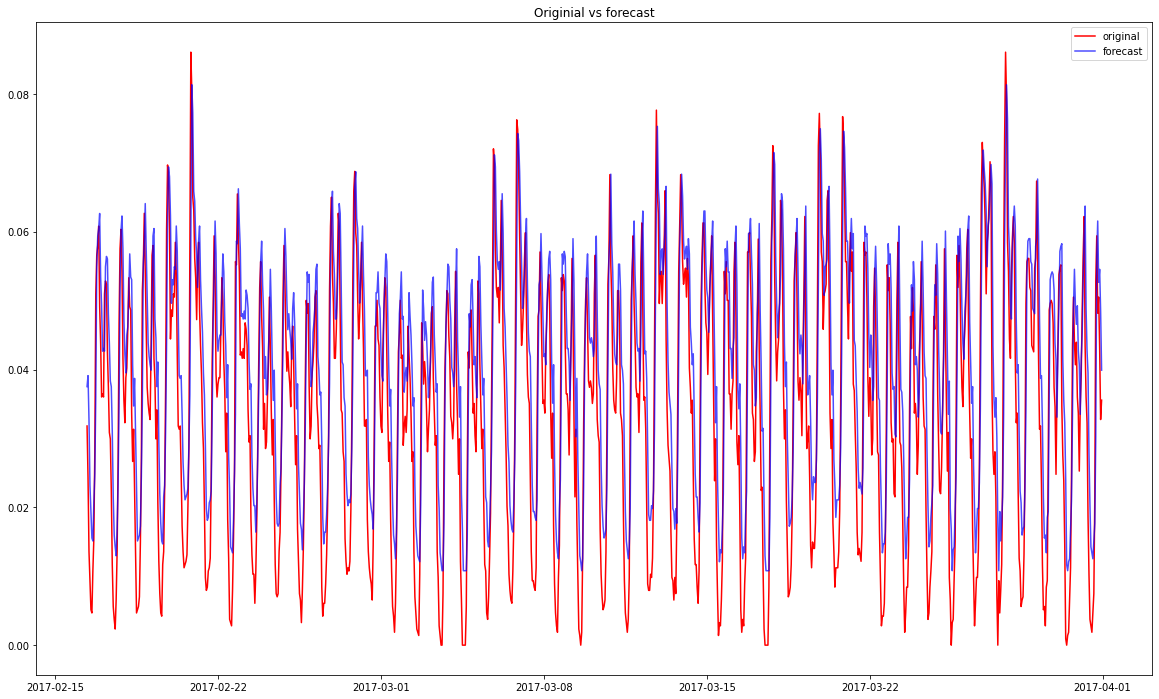

In [ ]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result.Date_time, result.original_value, color='red', label='original')
plt.plot(result.Date_time, result.predicted_value, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [ ]:
df.to_csv('raw_data.csv', index=False)
df.to_excel('raw_data.xls', index=False)

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import files

# e.g. save pandas output as csv
result.to_csv('DMA_225_ULSTM_modified.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_225_ULSTM_modified.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>